In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
np.random.seed(0)

# plotting parameters
plt.style.use('science')
plt.rcParams.update({
    "font.size":18})
figsize(8,5)

# I. Fuzzy K-Nearest Neighbour

> One of the difficulties that arises when utilizing this technique is that each of the labeled samples is given equal importance in deciding the class memberships of the pattern, regardless of their "typicalness" 

Using "fuzzy" sets we can:
- take into account that a point might be atypical of its class
- give confidence measures of the classification


# II. Crisp vs Fuzzy Sets

**Crisp sets**

Imagine we have a dataset (or *universe*) $U$ and an individual class of data (or *subset*) $A$.

For a datapoint $x$ we can say that it is either in the class $A$ or not like this:

$$
  u_A(x) =
  \begin{cases}
    1, & \quad x \in A  \\
    0, & \quad x \notin A 
  \end{cases}
$$

That is to say, either it's in the class or it's not. What if $x$ is really an extreme outlier for the set $A$? In KNN we just set a binary indicator, and don't specify any degree of membership.

An example of a "crisp" set:

$$
  u_A(x) =
  \begin{cases}
    1, & \quad x \leq 5 \\
    0, & \quad x \gt 5  \\ 
  \end{cases}
$$

We can visualise this like a step function:

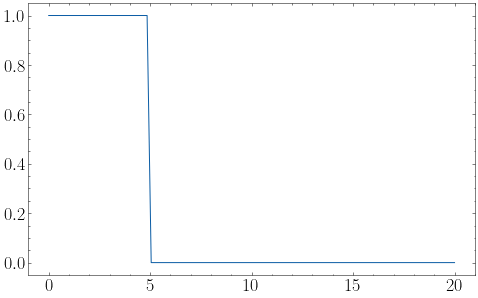

In [2]:
def u(x):
    return x <= 5

x = np.linspace(0,20,100)
y = u(x)

fig, ax = plt.subplots()
ax.plot(x,y);

**Fuzzy sets**

Set of real numbers much larger than zero:
$$
  u(x) =
  \begin{cases}
    x^2 / (x^2+1), & \quad x \geq 0  \\
    0, & \quad x \leq 0
  \end{cases}
$$

I think it's helpful to visualise the positive number case:

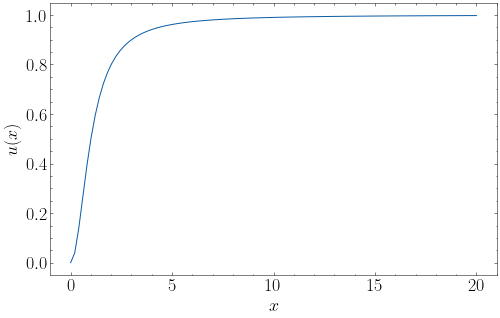

In [3]:
def u(x):
    return x**2 / (x**2 + 1)

x = np.linspace(0,20,100)
y = u(x)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x)$");

This gives us two things:
1. We can express whether an object is typical or atypical for its class
2. We can give degrees of certainty 

**Fuzzy partitions**

> For a set of vectors $\{ x_1,...,x_n \}$, a fuzzy partition of these vectors specifies the degree of membership of each vector

e.g. 10 is *sort of* bigger than zero, 100 is *definitely* bigger than zero. 


Setup:
- we have $c$ classes
- we have $n$ points 
- we have $u_C(x)$ - the degree of membership of class $C$

Our partition is a $c \times n$ matrix: each **row** is a list of the degrees of membership for each of the $n$ points. 

We have some constraints:
- the sum of each column must be one (e.g. the column for $x_0$ might be $[0.3,0.7]$ for two classes) 
- the sum of each row should be between one and $n$ (e.g. there are no negative memberships or individual memberships greater than one)

Each matrix element of $U$ is therefore: $\color{red}{u_{ik} = u_i(x_k)}$ - this will come up later.

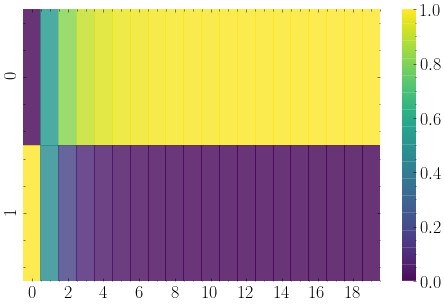

In [4]:
def u(x):
    return x**2 / (x**2 + 1)

c = 2  # number of classes
n = 20 # number of datapoints

# generate data
x = np.linspace(0,20,20)

# fuzzy partition matrix
U = np.zeros((c, n))
U[0,:] = u(x) 
U[1,:] = 1-u(x)

sns.heatmap(U, cmap='viridis', alpha=.8);

$x^2 + 1$ is always bigger than $x^2$ - so $u(x)$ can never be bigger than one.

# III. The KNN Algorithm

What does the data look like?

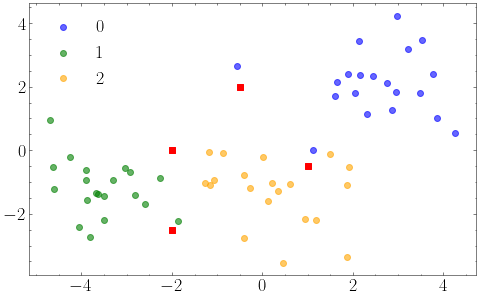

In [5]:
n = 20

c_0 = np.random.normal([2,2],  1, size=(n,2)) # cluster centered at [2,2]
c_1 = np.random.normal([-3,-1],1, size=(n,2)) # cluster centered at [-3,-1]
c_2 = np.random.normal([0,-2], 1, size=(n,2)) # cluster centered at [0,-2]

y = np.array([
    [-2, 0],
    [-2, -2.5],
    [-.5, 2], 
    [1, -.5],
])

colours = {
    0 : 'blue',
    1 : 'green',
    2 : 'orange',
}

def plot_data():    
    fig, ax = plt.subplots()

    for i, cluster in enumerate([c_0,c_1,c_2]):
        ax.scatter(cluster[:,0], cluster[:,1], color=colours[i], alpha=.6, label=i)

    ax.scatter(y[:,0], y[:,1], color='red', marker='s')
    ax.legend()
    
plot_data();

We can implement the Crisp KNN Algorithm a little more simply than the paper by using a [min heap](https://docs.python.org/3/library/heapq.html).

In [6]:
import operator
from heapq import heappush, heappop
from collections import defaultdict, namedtuple

targets = np.concatenate([np.zeros(n), np.ones(n), np.ones(n)*2])
X = np.concatenate([c_0, c_1, c_2])

# neighbour contains: dist and class
Neighbour = namedtuple('Neighbour', 'd c loc')

def get_k_nearest_neighbours(y,X,k=3):
    n = len(X)
    
    neighbours = []
    
    for i in range(n):
        x_i = X[i]
        
        # compute distance from y to x_i
        dist = -np.sqrt(abs(x_i[0] - y[0])**2 + abs(x_i[1] - y[1])**2)
        heappush(neighbours, Neighbour(dist, targets[i], tuple(x_i)))
   
        # if we have too many neighbours, remove the furthest 
        while(len(neighbours) > k):
            heappop(neighbours)
    return neighbours


def crisp_knn(y, X, targets, k=3):
    neighbours = get_k_nearest_neighbours(y,X,k)
                
    # get the classes of the neighbours
    classes = defaultdict(int)
    for neighbour in neighbours:
        classes[neighbour.c] += 1
        
    # lookup the max occurring class in the dictionary
    return int(max(classes.items(), key=operator.itemgetter(1))[0])         

Now we can classify our test points:

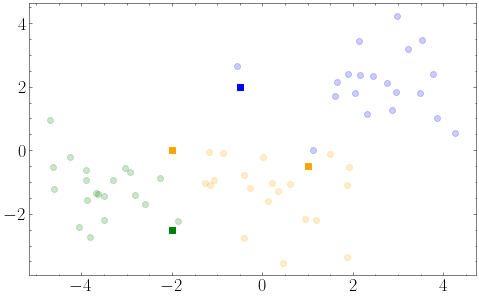

In [7]:
fig, ax = plt.subplots()

# plot the old points
for i, cluster in enumerate([c_0,c_1,c_2]):
    ax.scatter(cluster[:,0], cluster[:,1], color=colours[i], alpha=.2)

# classify and plot the new points
for y_i in y:
    c = crisp_knn(y_i, X, targets)
    ax.scatter(y_i[0], y_i[1], color=colours[c], marker='s')

**The Fuzzy KNN Algorithm**  

> Assign membership as a function of the vector's distance from its neighbours

The algorithms use the same method to find the neighbours, but now we have an additional function $u_i(x)$ which is defined by:

$$
u_i(x) = \frac{\color{teal}{\sum_{j=1}^{K} u_{ij}(1/||x - x_j||^{2/(m-1)})}}{\color{violet}{\sum_{j=1}^{K} (1/||x - x_j||^{2/(m-1)})}}
$$

Read this as: the membership amount per class is decided by **the inverse distances from the neighbours and their memberships**.

e.g. if vector is close $\rightarrow$ membership weighted higher, if vector is far $\rightarrow$ membership weighted lower.

Let's break it down.

On the left hand side we have:

$$
u_i(x) = 
$$

Which means we want to calculate the membership of $x$ of class $i$.

Now the numerator:

$$
\color{teal}{\sum_{j=1}^{K} u_{ij}(1/||x - x_j||^{2/(m-1)})}
$$


In code we can think of a $\sum_{j=1}^{K}$ as:


In [8]:
x = [-2, 0]
K = 3
for j in range(K):
    ## do something here
    pass

1. The $||x-x_j||$ part says: what is the distance between this point $x$ and the neighbour $x_j$. In linear algebra terms we call this the *norm*.

In [9]:
x = np.array([-2,0])
K = 3

# if X_ is our set of neighbours
X_ = [[-2,-1],[-2,-2],[-3,0]]

#sqrt((x[0] - x_j[0])**2 * (x[1] - x_j[1])**2)

for j in range(K):
    # distance from [-2,0] to X_[j]
    print(np.linalg.norm(x - X_[j]))

1.0
2.0
1.0


2. The expression $\color{teal}{2/(m-1)}$ is a *temperature variable* which scales how much we weight the distances. **As $m$ increases we begin to weight all distances equally**. 

To give you an illustration of what this looks like:

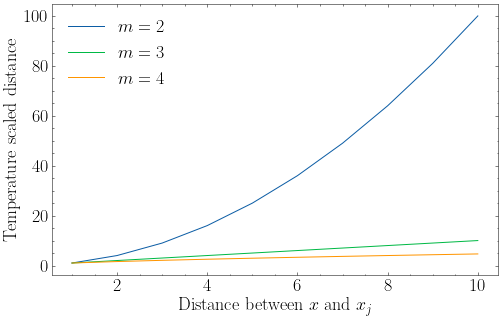

In [10]:
fig, ax = plt.subplots()

# imagine these are our norms
x = np.linspace(1,10,10) 

for m in [2,3,4]:
    ax.plot(x, x**(2/(m-1)), label=f"$m={m}$");
    
ax.set_xlabel("Distance between $x$ and $x_j$")
ax.set_ylabel("Temperature scaled distance")
ax.legend();

Essentially all this is saying is: the higher you set $m$, the more weight I want to give to closer samples. So if I have two nearest-neighbours, I want to give more importance to the closer of the two.

Remember above we stated that $\color{red}{u_ik = u_i(x_k)}$, and remember how to interpret the entries of the matrix $U$ - they are the **amount of membership of the datapoint $k$ to the class $i$**.

We multiply by this quantity to give us a weighting for each point. 

Let's start by computing the fuzzy membership of each of our training to points to each of the classes. We'll say that membership is defined as distance from the center of the cluster. 

In [11]:
def compute_centers(classes):
    centers = []
    
    for c in classes: 
        centers.append(np.mean(c, axis=0)) # axis=0 => keep them as vectors

    return centers

centers = compute_centers([c_0,c_1,c_2])
centers

[array([2.52676307, 2.09832188]),
 array([-3.54453107, -1.20272301]),
 array([ 0.22220974, -1.30437013])]

This is roughly in line with what we were expecting, since we generated the clusters ourselves to be centred at:

```
[2,2]
[-3,-1]
[0,-2]
```

Now for every point in the training set let's compute the distance from the center of its class, and use that as its **membership**. We'll use the same formula provided at the start of the paper:

$$
  u(x) =
  \begin{cases}
    x^2 / (x^2+1), & \quad x \gt 0  \\
    0, & \quad x \leq 0
  \end{cases}
$$

In [12]:
def compute_memberships(X, targets, centers):
    classes = set(targets)
    
    # membership will be a dictionary:
    #      point : [mem_0, mem_1, mem_2]
    
    memberships = defaultdict(list)
    
    for c, center in zip(classes, centers):
        for point in X:
            dist = 1/np.linalg.norm(point - center)    
            memberships[(point[0], point[1])].append(dist)
        
    return memberships

memberships = compute_memberships(X, targets, centers)

So you can see that we're giving higher precedence to whichever class the point `[1,1]` belongs to, and less precedence to whichever class `[3,3]` belongs to.

Now the denominator:

We divide this quantity by:
$$
\color{violet}{\sum_{j=1}^{K} (1/||x - x_j||^{2/(m-1)})}
$$

This is just the temperature scaled distance, without taking into account membership.

So overall we could write our expression as:

$$
\text{membership of } x \text{ to class } i = \frac{\color{teal}{\sum (\text{membership of neighbour}\times \text{distance})}}{\color{violet}{\sum \text{distance}}}
$$

In [13]:
# neighbour contains: dist and class
Neighbour = namedtuple('Neighbour', 'd c loc')

def fuzzy_knn(y, X, targets, memberships, k=3):
    neighbours = get_k_nearest_neighbours(y, X, k)
    
    class_memberships = {}
    
    m = 2

    for t in set(targets):
        den = 0
        for neighbour in neighbours:
            dist = np.linalg.norm(y - neighbour.loc)
            den += 1 / (dist ** (2 / (m-1)))

        neighbours_weights = []
        
        for neighbour in neighbours:
            dist = np.linalg.norm(y - neighbour.loc)
            num = (memberships[neighbour.loc][int(t)]) / (dist ** (2 / (m-1)))
            class_membership = num/den
            neighbours_weights.append(class_membership)
            
        class_memberships[t] = np.sum(neighbours_weights)

    return class_memberships

memberships = compute_memberships(X, targets, centers)

for y_i in y:
    print(f"{y_i} : {fuzzy_knn(y_i, X, targets, memberships)}")

[-2.  0.] : {0.0: 0.2170078456917917, 1.0: 0.5051693181421858, 2.0: 0.5033568820206836}
[-2.  -2.5] : {0.0: 0.16152682301409316, 1.0: 0.5747536656802618, 2.0: 0.42702043711024446}
[-0.5  2. ] : {0.0: 0.3679379573133612, 1.0: 0.21323900958740546, 2.0: 0.2816943578080203}
[ 1.  -0.5] : {0.0: 0.3691741742246313, 1.0: 0.2117908717911093, 2.0: 1.012572268364658}


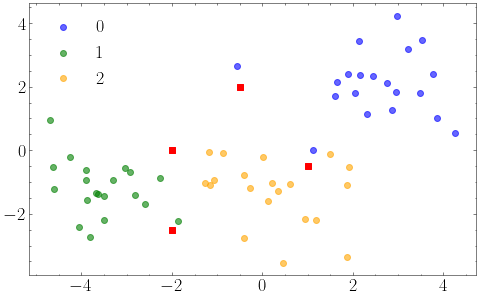

In [14]:
plot_data();

## Results

They make use of the Iris dataset, which has become something of a classic classification dataset. For reference, it looks like this:

In [15]:
from sklearn.datasets import load_iris
import pandas as pd 

data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
